Training Mini-batch GD Logistic Regression...
Performing grid search...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters found:
alpha: 0.01
eta0: 0.5
learning_rate: adaptive
max_iter: 1000
tol: 0.001

FINAL MODEL PERFORMANCE:
Best CV Score (F1): 0.3406
Test Accuracy: 0.7787
Test Precision: 0.5781
Test Recall: 0.2591
Test F1: 0.3578
Test ROC AUC: 0.8044

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2286
           1       0.58      0.26      0.36       714

    accuracy                           0.78      3000
   macro avg       0.69      0.60      0.61      3000
weighted avg       0.75      0.78      0.75      3000


Confusion Matrix:
[[2151  135]
 [ 529  185]]


<Figure size 1000x600 with 0 Axes>

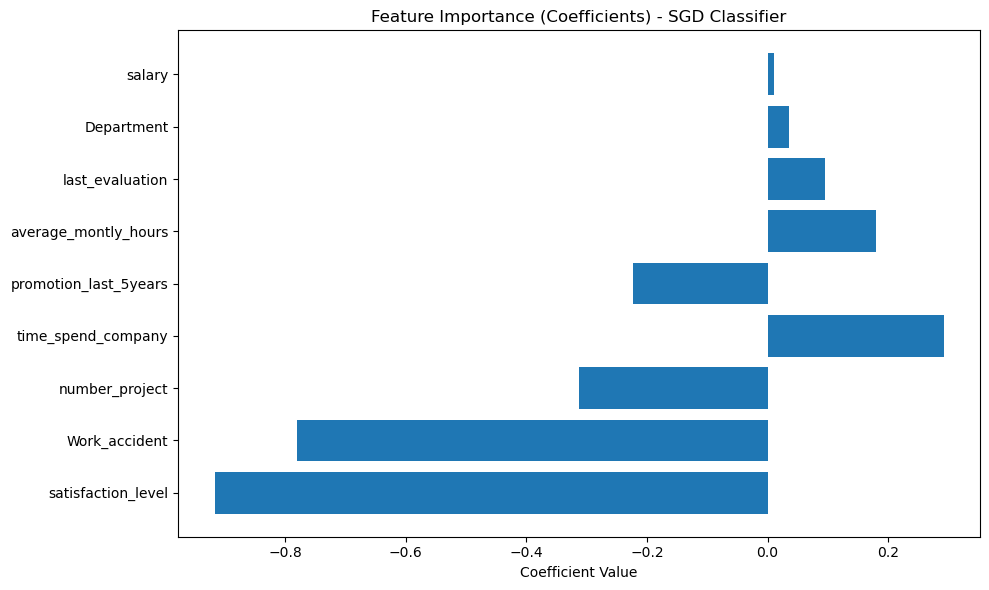


Top 10 Most Important Features:
                 feature  coefficient
0     satisfaction_level    -0.917283
5          Work_accident    -0.780949
2         number_project    -0.312318
4     time_spend_company     0.291642
6  promotion_last_5years    -0.223704
3   average_montly_hours     0.179656
1        last_evaluation     0.095590
7             Department     0.035655
8                 salary     0.010640

Best model saved as 'sgd_best_model.pkl'


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
from data.hr_data_prep import prepare_data


# Load and prepare data
df = pd.read_csv('data/HR_data.csv')
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df)

print("Training Mini-batch GD Logistic Regression...")
print("="*50)

# Define the model
sgd_model = SGDClassifier(loss='log_loss', random_state=42, early_stopping=True)

# Define hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-4]
}

# Perform grid search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    sgd_model, param_grid, cv=cv, scoring='f1', 
    n_jobs=-1, verbose=1
)

print("Performing grid search...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Train final model with best parameters
best_sgd_model = grid_search.best_estimator_
best_sgd_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_sgd_model.predict(X_test)
y_pred_proba = best_sgd_model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE:")
print("="*50)
print(f"Best CV Score (F1): {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_pred):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot learning curve (simulated)
plt.figure(figsize=(10, 6))
# For SGDClassifier, we can look at the loss curve if we set verbose=1 during fit
# Alternatively, we can plot the training progress by storing loss at each iteration

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_sgd_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.title('Feature Importance (Coefficients) - SGD Classifier')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Save the model
import joblib
joblib.dump(best_sgd_model, 'sgd_best_model.pkl')
print("\nBest model saved as 'sgd_best_model.pkl'")